In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.ndimage as ndi

In [ ]:
# this code is a complete mess because I kept adding things whenever I had a rat that failed to work
# the process path function should work if you just point it at a folder of rat lungs
# let me know if you have issues

In [3]:
def split_left_right(fname, show = False, debug = False, flip_180 = False):
    data = np.loadtxt(fname, skiprows = 1, delimiter = ',')
    
    errors = 0
    
    # first lets spin the lungs and find where they are narrowest when viewed side on
    
    angles_to_try = np.linspace(0, 360, 600)
    peak_heights = []
    std_approxs = []
    angles = []
    
    
    for angle in angles_to_try:
        try:
            p, st = get_narrowness(data, angle, debug)
            peak_heights.append(abs(p))
            std_approxs.append(-abs(st))
            angles.append(angle)
        except NotImplementedError:
            errors +=1
            if debug:
                print('something went wrong')
        except RuntimeError:
            print('Had a runtime error on the narrowness fitting, lets see if it all works')
            
    width_appr = ndi.median_filter(std_approxs,5)
    amp = abs(np.max(width_appr) - np.min(width_appr))
    shift = np.min(width_appr)
    
    print(amp)
    print(shift)
    
    vals1, errr1, id1, others, others2 = scipy.optimize.curve_fit(periodic_function, angles, width_appr, p0=[amp, 45,shift], 
                                                                  bounds = [[amp - 1, -180, shift - 1], [amp + 1, 180, shift + 1]], full_output= True)
    vals2, errr2, id2, others, others2 = scipy.optimize.curve_fit(periodic_function, angles, width_appr, p0=[amp,-45,shift],
                                                                  bounds = [[amp - 1, -180, shift - 1], [amp + 1, 180, shift + 1]], full_output= True)
    
    bfp1 = np.sum(id1['fvec']**2)/id1['fvec'].size
    bfp2 = np.sum(id2['fvec']**2)/id2['fvec'].size
    
    if bfp1 > bfp2:
        vals = vals1
    else:
        vals = vals2
    

    phase = vals[1]
    phase = (phase%180) - 90
    print(vals)
    
    xfp = np.arange(0, 360, 0.1)
    y_fit = periodic_function(xfp, vals[0], vals[1], vals[2])
            
    if show:
        
        plt.figure()
        plt.suptitle('Spinning full 360 - narrowest in Y at {}'.format(phase))
        plt.subplot(211)
        plt.scatter(angles, width_appr)
        
        plt.plot(xfp, y_fit)
        plt.subplot(212)
        plt.scatter(angles, peak_heights)
        
        plt.show()
    
    
    # now rotate the image until the two peaks are most separate from each other
    angles_to_try = np.linspace(phase - 20, phase + 20, 200)
    seps = []
    angles = []
    
    
    for angle in angles_to_try:
        try:
            
            seps.append(get_separation_of_peaks_and_cutoff(data, angle, debug)[0])
            angles.append(angle)
        except RuntimeError:
            errors +=1
            if debug:
                print('Looks like angle {} made me A N G E R Y'.format(angle))
        except NotImplementedError:
            errors +=1
            if debug:
                print('A value was strange at angle {}!'.format(angle))
    
    # finding peak of curve of separations
    vals, errs = scipy.optimize.curve_fit(quick_gauss, angles, ndi.median_filter(seps, 3), p0=[6,1,phase], maxfev = 20000)
    peak_angle = vals[2]
    
    if show:
        xfp = np.arange(phase-25, phase + 25, 0.1)
        y_fit = quick_gauss(xfp, vals[0], vals[1], vals[2])
        plt.figure()
        plt.scatter(angles, ndi.median_filter(seps, 3))
        plt.scatter(angles, seps)
        plt.plot(xfp, y_fit)
        plt.plot([peak_angle, peak_angle],[y_fit.min(), y_fit.max()])
        
        plt.xlabel('Rotation Angle (Degrees)')
        plt.ylabel('Separation of centres of lungs')
        plt.title('Lungs are face-on at {} Degrees'.format(peak_angle))
        plt.show()
    
    if flip_180 == True:
        peak_angle += 180
        
    for i in range(10):
        try:
            cut_off_point = get_separation_of_peaks_and_cutoff(data, peak_angle, True)[1]
            break
        except:
            print('Failed to get a cut-off point, adding 0.05 to angle and retrying')
            peak_angle += 0.05
    
    data_out = split_the_data(data, peak_angle, cut_off_point)
    
    return data_out, peak_angle

In [6]:
def quick_gauss(x, a, b, c):
    return abs(a) * np.exp(-1 * ((x-c)/b)**2)

def double_guass(x, a_1, a_2, b_1, b_2, c_1, c_2):
    g1 = quick_gauss(x, a_1, b_1, c_1)
    g2 = quick_gauss(x, a_2, b_2, c_2)
    return g1 + g2

def periodic_function(angle, amp, phase, height_shift):
    '''x is in degrees'''
    theta = (angle - phase) * np.pi/180
    return abs(amp * (np.sin(theta))) + height_shift
    
def rotate_and_cols(data, angle):
    '''Angle is in degrees'''
    xs = data[:,1]
    ys = data[:,2]
    zs = data[:,3]
    vals = data[:,0]
    
    #do the rotation
    theta = angle * np.pi/180
    xnew = np.cos(theta)*xs - np.sin(theta)*ys
    ynew = np.sin(theta)*xs + np.cos(theta)*ys
    
    return xnew, ynew, zs, vals

In [7]:
def get_separation_of_peaks_and_cutoff(data, angle, show = False):
    xs, ys, zs, vals = rotate_and_cols(data, angle)
    
    # taking seeing if chopping down the data in z to where the lungs are more separate makes things easier
    z25 = np.percentile(zs,20)
    
    x_zchop = []
    y_zchop = []
    for i in range(len(zs)):
        if zs[i] < z25:
            x_zchop.append(xs[i])
            y_zchop.append(ys[i])
        
    x_zchop = np.asarray(x_zchop)
    y_zchop = np.asarray(y_zchop)
            
    
    # histogram of the data in X
    hist, edges = np.histogram(x_zchop, 30)
    
    # remove the empty datapoints from binaristaion using some funky syntax
    removed = np.where(hist > 1, edges[:-1], 0)
    cut_x = removed[removed !=0]
    cut_y = hist[removed !=0] 
    
    # fit a double gaussian to the data
    vals, errs = scipy.optimize.curve_fit(double_guass, cut_x, cut_y, p0 = [200, 200, 1,1,-4,4], maxfev = 20000)
    
    # separation is the distance between the two peaks
    sep = abs(vals[5]-vals[4])
    
    if sep > 25:
        if True:
            print('Separation that is too big detected - value is {}'.format(sep))
        raise NotImplementedError
    
    x_fit = np.arange(cut_x.min(), cut_x.max(),0.1)
    y_fit = double_guass(x_fit, vals[0], vals[1], vals[2], vals[3], vals[4], vals[5])
    
    # finding the positions of the two peaks (cant be sure which is which so do upper and lower of the two values)
    lower_bound = vals[4:].min()
    upper_bound = vals[4:].max()
    
    # some one-line for loops to get only the values between the peaks so we can find the min there
    middle_x = [xv for xv in x_fit if upper_bound > xv > lower_bound]
    middle_val = [y_fit[i] for i in range(len(y_fit)) if upper_bound > x_fit[i] > lower_bound]
    
    # position of minimum
    if len(middle_val) > 2:
        cut_off_point = middle_x[np.argmin(middle_val)]
    else:
        raise NotImplementedError
       
    
    if show:
        plt.figure()
        plt.suptitle('Angle is {}'.format(angle))
        ax1 = plt.subplot(211)
        zlow = 0
        zhigh = -1
        plt.scatter(xs[zlow:zhigh], ys[zlow:zhigh])
        plt.scatter(x_zchop, y_zchop)
        
        ax2 = plt.subplot(212, sharex = ax1)
                
        plt.plot(x_fit, y_fit)
        plt.scatter(cut_x, cut_y)
        plt.plot([cut_off_point, cut_off_point],[y_fit.min(), y_fit.max()])
        
        plt.plot(middle_x, middle_val)
        
        plt.show()
    
    # defining an angular goodness as separation is not always the best
    peak_1_height = vals[0]
    peak_2_height = vals[1]
    trough_height = np.min(middle_val)
    h1 = peak_1_height - trough_height
    h2 = peak_2_height - trough_height
    max_height = np.max(np.array([h1, h2]))
        
    return sep, cut_off_point    
    #return sep, cut_off_point
    

In [8]:
def get_narrowness(data, angle, show = False):
    xs, ys, zs, vals = rotate_and_cols(data, angle)
    
    # taking seeing if chopping down the data in z to where the lungs are more separate makes things easier
    z25 = np.percentile(zs,95)
    
    x_zchop = []
    y_zchop = []
    for i in range(len(zs)):
        if zs[i] < z25:
            x_zchop.append(xs[i])
            y_zchop.append(ys[i])
        
    x_zchop = np.asarray(x_zchop)
    y_zchop = np.asarray(y_zchop)
            
    
    # histogram of the data in Y
    hist, edges = np.histogram(y_zchop, 50)
    
    # remove the empty datapoints from binaristaion using some funky syntax
    removed = np.where(hist > 1, edges[:-1], 0)
    cut_x = removed[removed !=0]
    cut_y = hist[removed !=0] 
    
    # fit a double gaussian to the data
    vals, errs = scipy.optimize.curve_fit(quick_gauss, cut_x, cut_y, p0 = [np.max(cut_y), 1, -5],maxfev = 20000)
    
    # separation is the distance between the two peaks
    peak_height = vals[0]
    stdish = vals[1]

    
    x_fit = np.arange(cut_x.min(), cut_x.max(),0.1)
    y_fit = quick_gauss(x_fit, vals[0], vals[1], vals[2])
    
   
    if show:
        plt.figure()
        plt.suptitle('Looking at Narrowness - Angle is {}'.format(angle))
        ax1 = plt.subplot(211)
        zlow = 0
        zhigh = -1
        plt.scatter(xs[zlow:zhigh], ys[zlow:zhigh])
        plt.scatter(x_zchop, y_zchop)
        
        ax2 = plt.subplot(212, sharex = ax1)
                
        plt.plot(x_fit, y_fit)
        plt.scatter(cut_x, cut_y)
      
        plt.show()
    
    if abs(stdish) > 50:
        #print('here')
        raise NotImplementedError
    elif abs(peak_height) < 70:
        #print('and here')
        raise NotImplementedError
   
    return peak_height, stdish 
    #return sep, cut_off_point
    

In [9]:
def split_the_data(data, angle, cut_off_point):
    xs, ys, zs, vals = rotate_and_cols(data, angle)
    
    lung_a = np.zeros_like(vals)
    lung_a[:] = np.nan
    lung_b = np.zeros_like(vals)
    lung_b[:] = np.nan
    
    for i in range(len(xs)):
        if xs[i] < cut_off_point:
            lung_a[i] = vals[i]
        else:
            lung_b[i] = vals[i]
            
    # time for some stupid stuff
    zs_a = (lung_a*zs)/lung_a
    min_a = np.nanmin(zs_a)
    max_a = np.nanmax(zs_a)
    half_way_a = (min_a + max_a)/2 
    
    zs_b = (lung_b*zs)/lung_b
    min_b = np.nanmin(zs_b)
    max_b = np.nanmax(zs_b)
    half_way_b = (min_b + max_b)/2
    
    lung_a_upper = np.zeros_like(vals)
    lung_a_upper[:] = np.nan
    lung_a_lower = np.zeros_like(vals)
    lung_a_lower[:] = np.nan
    
    for i in range(len(zs)):
        if zs[i] > half_way_a:
            lung_a_upper[i] = lung_a[i]
        else:
            lung_a_lower[i] = lung_a[i]
            
    lung_b_upper = np.zeros_like(vals)
    lung_b_upper[:] = np.nan
    lung_b_lower = np.zeros_like(vals)
    lung_b_lower[:] = np.nan
    
    for i in range(len(zs)):
        if zs[i] < half_way_b:
            lung_b_upper[i] = lung_b[i]
        else:
            lung_b_lower[i] = lung_b[i]
            
    data_out = np.empty((data.shape[0], data.shape[1]+6))
    data_out[:,:4] = data
    data_out[:,4] = lung_a
    data_out[:,5] = lung_b
    
    data_out[:,6] = lung_a_lower
    data_out[:,7] = lung_a_upper
    
    data_out[:,8] = lung_b_lower
    data_out[:,9] = lung_b_upper
    
    return data_out

['3756.Phe508.beads.specificVentilation.csv', '3757.KO.beads.specificVentilation.csv', '3761.WT.beads.specificVentilation.csv', '3890.KO.beads.specificVentilation.csv', '4053.Phe508.beads.specificVentilation.csv', '4570.KO.beads.specificVentilation.csv', '4572.KO.beads.specificVentilation.csv', 'S12.WT.beads.specificVentilation.csv', 'S15.Phe508.beads.specificVentilation.csv', 'S187.WT.beads.specificVentilation.csv']
starting on 3756.Phe508.beads.specificVentilation.csv
6.9676232388233466
-10.242754358842294
[  6.9640003  -51.28252467 -10.31481851]


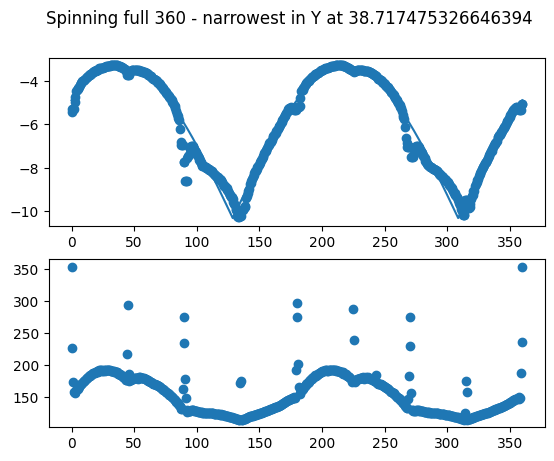

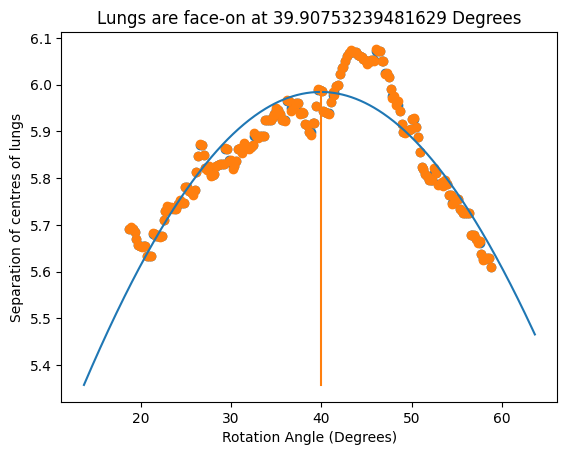

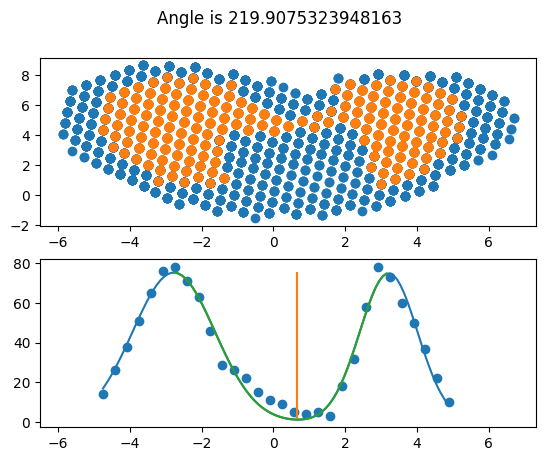

C:\Users\a1232489\AppData\Local\Temp\ipykernel_20996\1488936507.py:16: RuntimeWarning: invalid value encountered in divide
  zs_a = (lung_a*zs)/lung_a
C:\Users\a1232489\AppData\Local\Temp\ipykernel_20996\1488936507.py:21: RuntimeWarning: invalid value encountered in divide
  zs_b = (lung_b*zs)/lung_b


T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\3756.Phe508.beads.specificVentilation_split_upperlower_angle_219.908.csv
starting on 3757.KO.beads.specificVentilation.csv
5.723863035062408
-9.1599651402565
[  5.97811684 -34.26337518  -9.48249376]


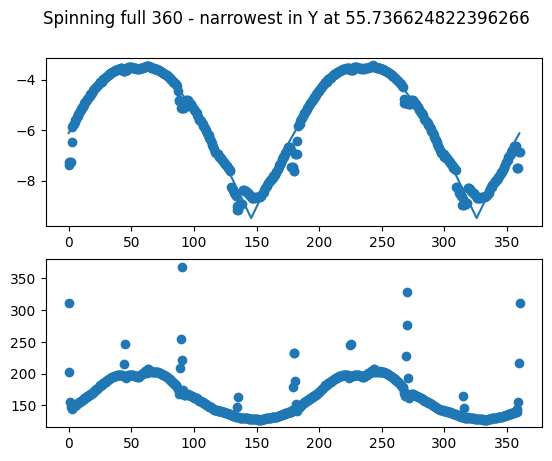

Separation that is too big detected - value is 1812.9929471913222


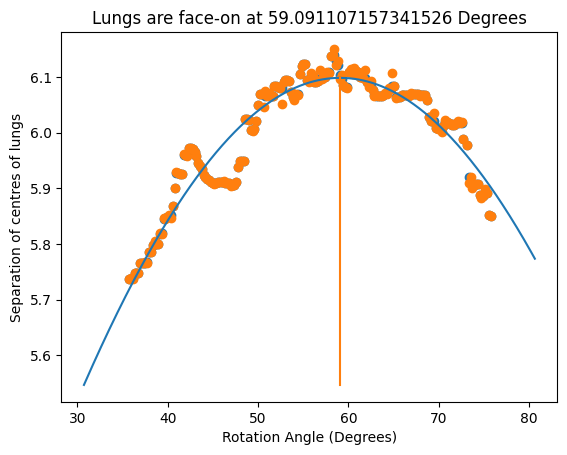

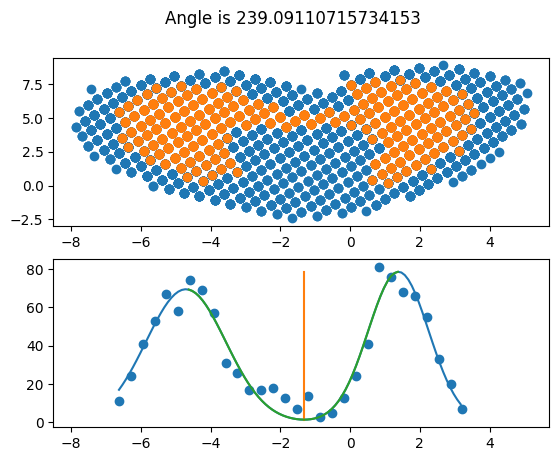

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\3757.KO.beads.specificVentilation_split_upperlower_angle_239.091.csv
starting on 3761.WT.beads.specificVentilation.csv
5.041175623805639
-8.894648038274884
[  5.80832925 -41.58395908  -9.72410893]


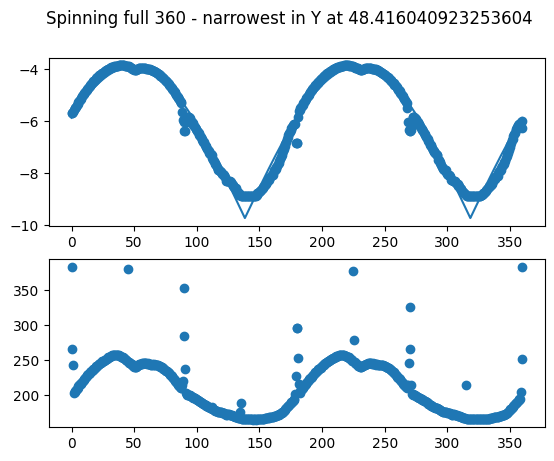

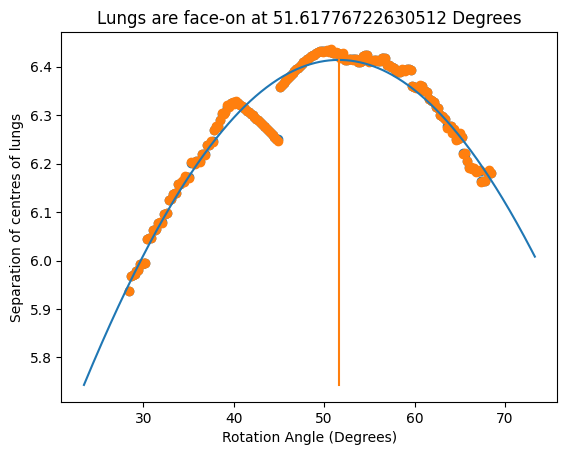

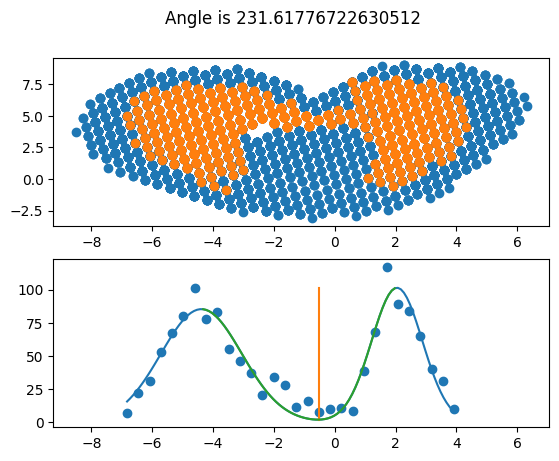

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\3761.WT.beads.specificVentilation_split_upperlower_angle_231.618.csv
starting on 3890.KO.beads.specificVentilation.csv
8.096105941135471
-9.096105941135471
[  7.09610594 -43.84100937 -10.09610594]


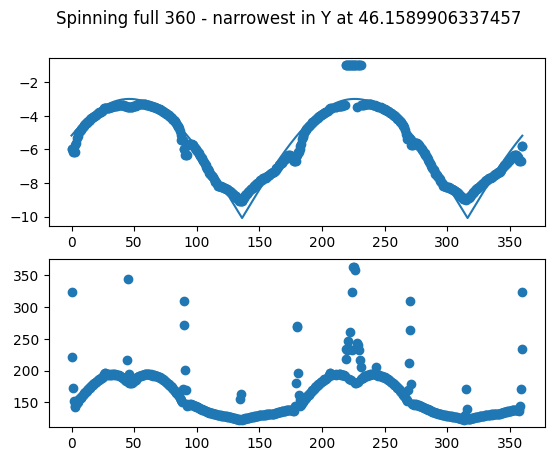

Separation that is too big detected - value is 201.50744071847788
Separation that is too big detected - value is 748.6592798660658
Separation that is too big detected - value is 660.5813807676752
Separation that is too big detected - value is 641.8911818327477
Separation that is too big detected - value is 455.18743758730704


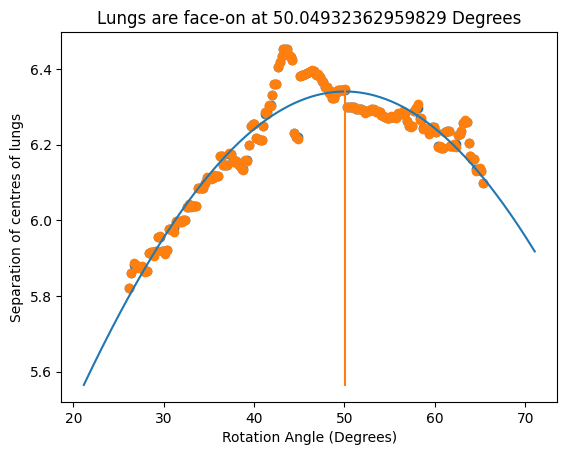

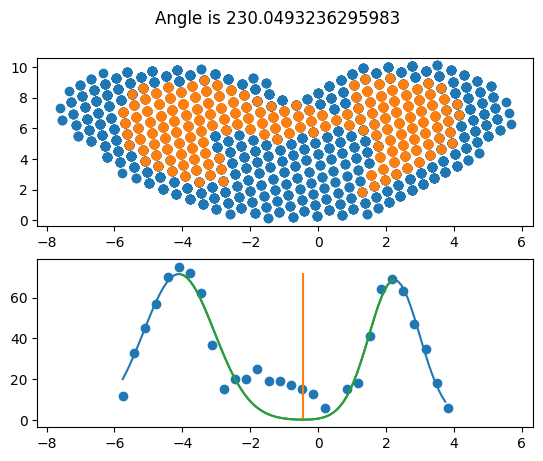

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\3890.KO.beads.specificVentilation_split_upperlower_angle_230.049.csv
starting on 4053.Phe508.beads.specificVentilation.csv
17.8208572294117
-20.84036669787172
[ 18.82085723 -44.76481911 -19.8403667 ]


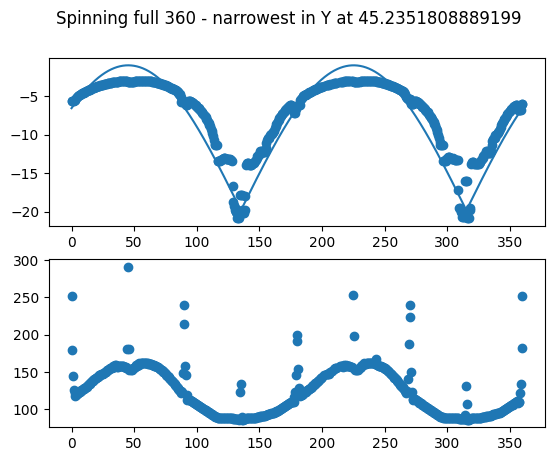

Separation that is too big detected - value is 999.9793199420614


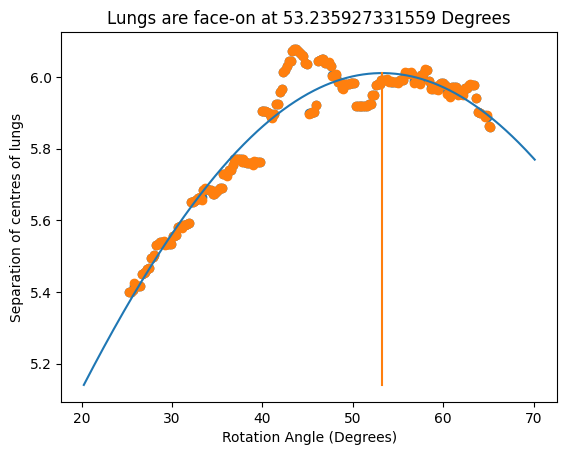

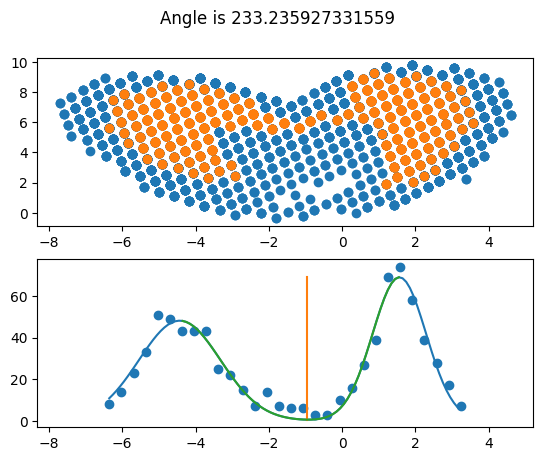

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\4053.Phe508.beads.specificVentilation_split_upperlower_angle_233.236.csv
starting on 4570.KO.beads.specificVentilation.csv
16.13213575329747
-17.13213575329747
[ 15.13213575  82.58863608 -18.13213575]


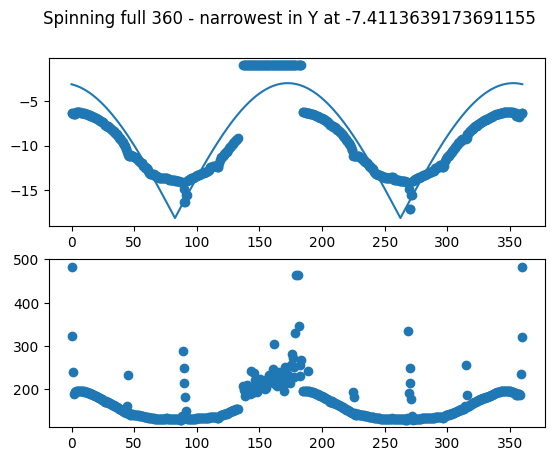

Separation that is too big detected - value is 2319.57258141083


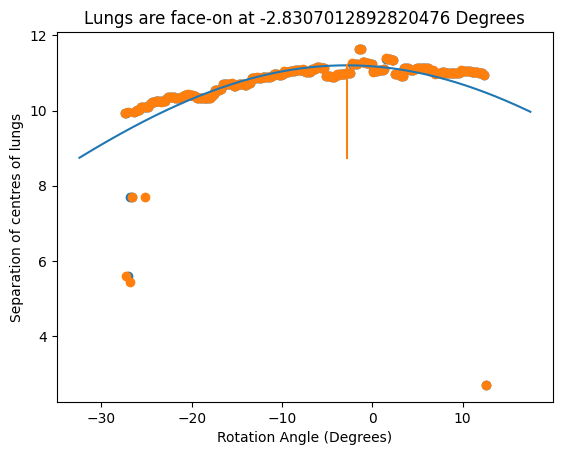

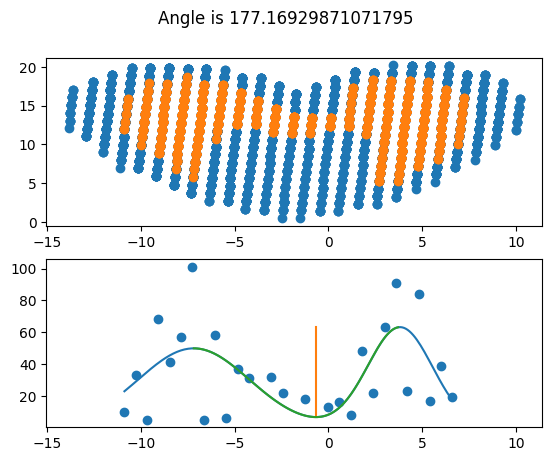

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\4570.KO.beads.specificVentilation_split_upperlower_angle_177.169.csv
starting on 4572.KO.beads.specificVentilation.csv
20.895443631998127
-21.895443631998127
[ 19.89544363  84.69893157 -22.60513598]


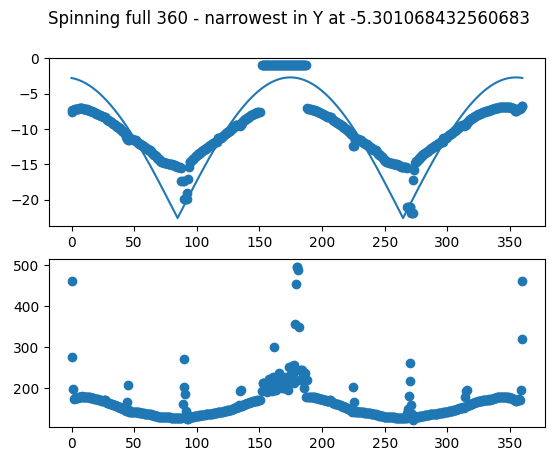

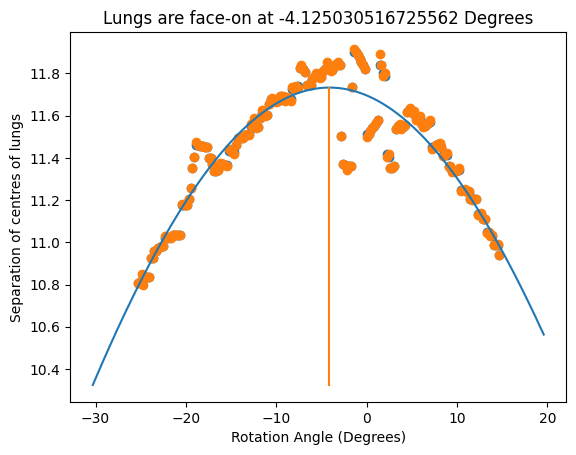

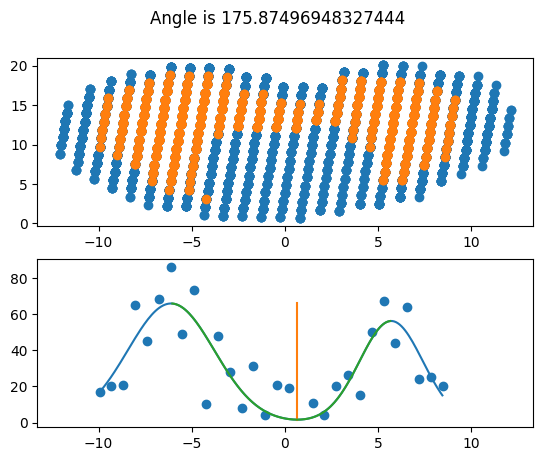

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\4572.KO.beads.specificVentilation_split_upperlower_angle_175.875.csv
starting on S12.WT.beads.specificVentilation.csv
23.724512200991846
-28.14971529391918
[ 22.7245122   98.84229093 -27.36779354]


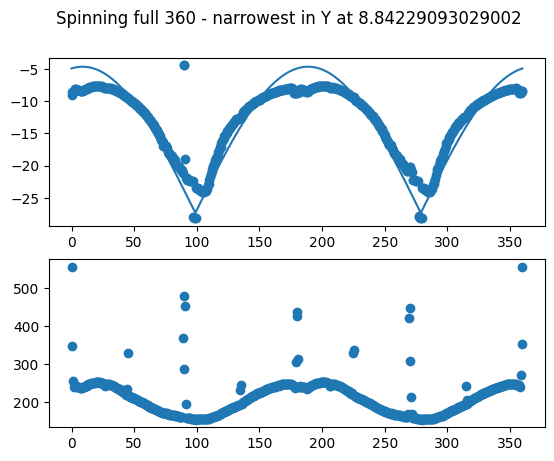

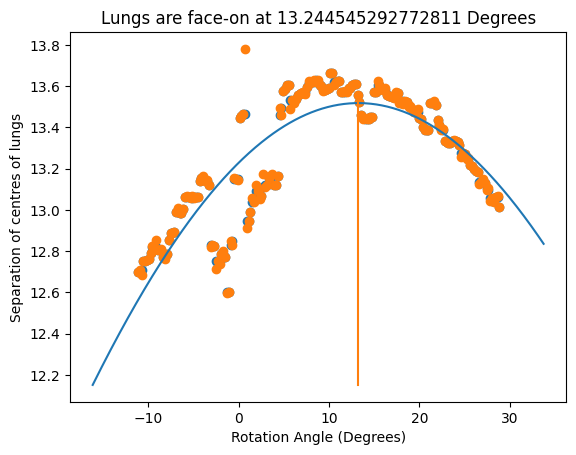

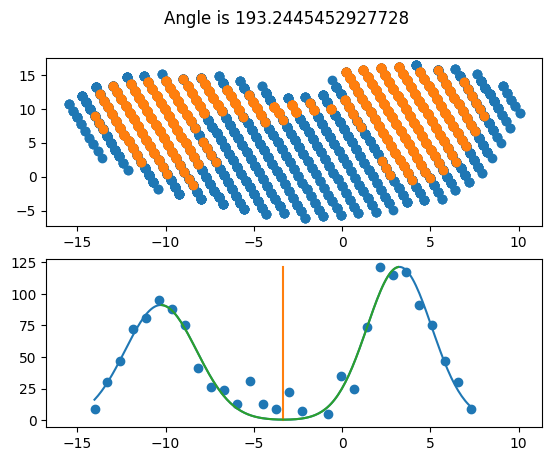

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\S12.WT.beads.specificVentilation_split_upperlower_angle_193.245.csv
starting on S15.Phe508.beads.specificVentilation.csv
20.54266213027939
-27.58194836236076
[ 21.51228819 -92.23671444 -26.58194836]


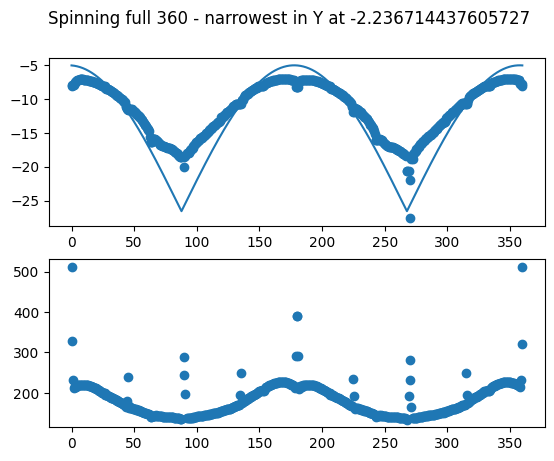

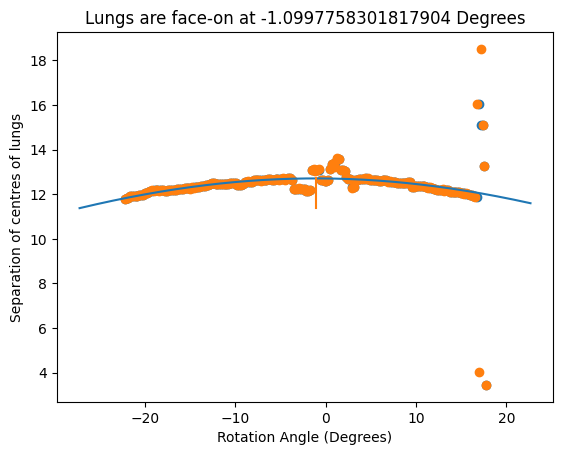

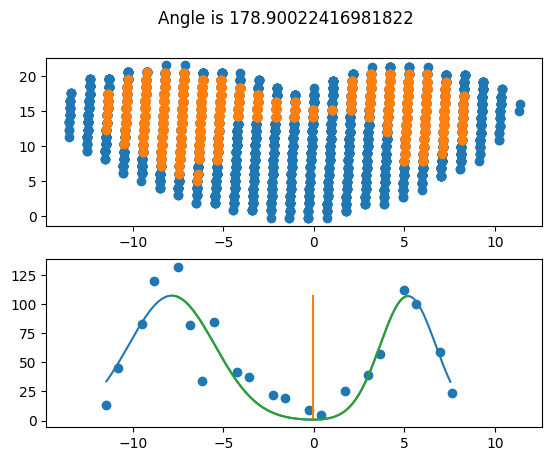

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\S15.Phe508.beads.specificVentilation_split_upperlower_angle_178.9.csv
starting on S187.WT.beads.specificVentilation.csv
19.763828098081735
-26.957649721631412
[ 20.47348547  87.28235222 -25.95764972]


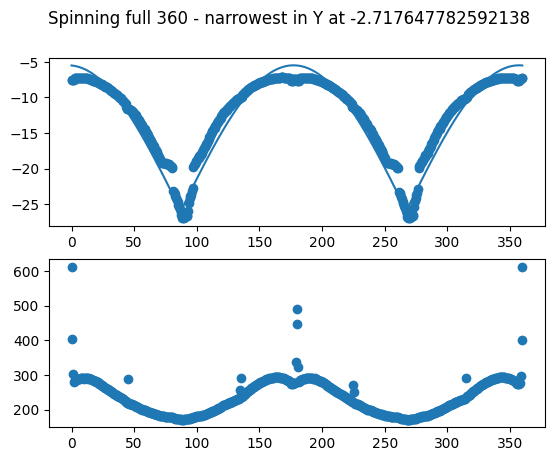

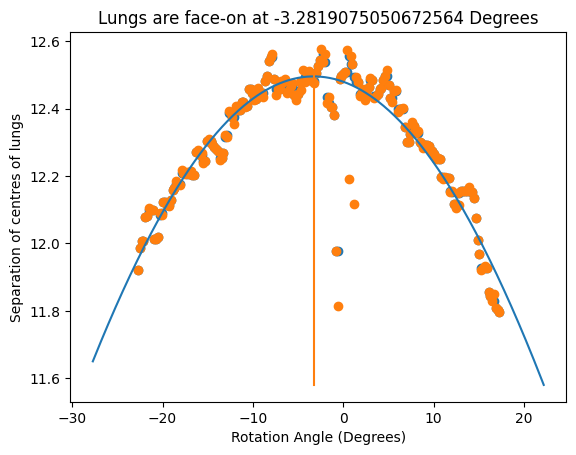

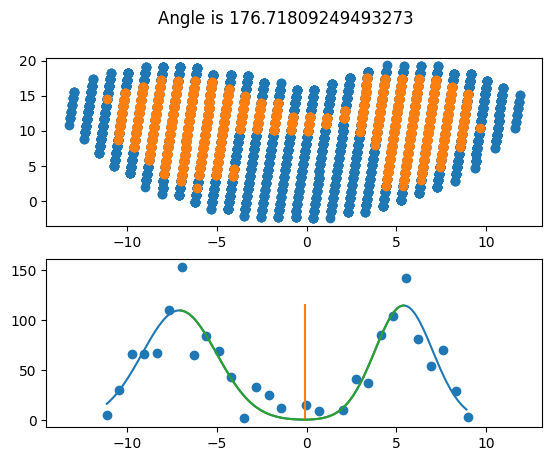

T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\output_files_upperlower\\S187.WT.beads.specificVentilation_split_upperlower_angle_176.718.csv
It finally works


In [13]:
def process_path(path, fname = True):
    
    if fname == True:
        fnames_a = os.listdir(path)
        fnames = []
        for f in fnames_a:
            if f[-5:] == 'n.csv':
                fnames.append(f)
        print(fnames)
    
    else:
        fnames = []
        fnames.append(fname)

    for fname in fnames:
        if fname[-4:] == '.csv':
            print('starting on {}'.format(fname))
            if fname[:3] == 'S66':
                dout, angle = split_left_right(path + fname, True, False, False)
            else:
                dout, angle = split_left_right(path + fname, True, False, True)

            savepath = path + 'output_files_upperlower\\'
            if not os.path.exists(savepath):
                os.mkdir(savepath)

            savename = savepath + '\\' + fname[:-4] + '_split_upperlower_angle_' + str(round(angle, 3)) + '.csv' 
            print(savename)
            header = 'Specific Venitlation, x, y, z, left_lung, right_lung, left_lung_upper, left_lung_lower, right_lung_upper, right_lung_lower'
            np.savetxt(savename, X = dout, delimiter = ',', header = header, comments = '')
            
#fname = r'T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\All data\\'
fname = r'T:\Imaging\SAHMRI\Permetium\CF - Pseudomonas\Output\Specific Ventilation\right_beads_for_comparison\\'
files = []
#for file in files:
process_path(fname,  True)

print('It finally works')

In [34]:
arr_a = np.array([1, np.nan])
arr_b = np.array([1,1])

In [36]:
(arr_a * arr_b)/arr_a

array([ 1., nan])

In [40]:
np.nanmin(arr_a)

1.0

In [11]:
(42%180) - 90

-48

In [37]:
fname = r'T:\Imaging\SAHMRI\Permetium\CF - Sterile Beads\Output\Specific Ventilation\Baseline\All data\\'

files = sorted(os.listdir(fname))
print(files)

['3751.Phe508.specificVentilation.csv', '3754.Phe508.specificVentilation.csv', '3756.Phe508.specificVentilation.csv', '3757.KO.specificVentilation.csv', '3761.WT.specificVentilation.csv', '3774.WT.specificVentilation.csv', '3890.KO.specificVentilation.csv', '4053.Phe508.specificVentilation.csv', '4055.Phe508.specificVentilation.csv', '4570.KO.specificVentilation.csv', '4572.KO.specificVentilation.csv', '4869.WT.specificVentilation.csv', 'S11.KO.specificVentilation.csv', 'S12.WT.specificVentilation.csv', 'S13.WT.specificVentilation.csv', 'S14.WT.specificVentilation.csv', 'S15.Phe508.specificVentilation.csv', 'S17.Phe508.specificVentilation.csv', 'S187.WT.specificVentilation.csv', 'S52.KO.specificVentilation.csv', 'S8.KO.specificVentilation.csv', 'output_files_upperlower']
